In [1]:

import pathlib
import glob
import os
import collections
import json
from omegaconf import OmegaConf

import pickle
import sys
import glob
from pathlib import Path, PurePath
path = Path.cwd()
parent_path = path.parents[1]
sys.path.append(str(PurePath(parent_path, 'neuroformer')))
sys.path.append('neuroformer')
sys.path.append('.')
sys.path.append('../')

import pandas as pd
import numpy as np
from einops import rearrange

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data.dataloader import DataLoader

import math
from torch.utils.data import Dataset

from neuroformer.model_neuroformer import GPT, GPTConfig, neuralGPTConfig
from neuroformer.trainer import Trainer, TrainerConfig
from neuroformer.utils import set_seed, update_object, check_common_attrs
from neuroformer.visualize import set_plot_params
from neuroformer.SpikeVidUtils import round_n, set_intervals
set_plot_params()

from scipy import io as scipyio
from scipy.special import softmax
import skimage
import skvideo.io
from scipy.ndimage import gaussian_filter, uniform_filter

parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"
import argparse

def parse_args():
    parser = argparse.ArgumentParser()
    # parser.add_argument("--infer", action="store_true", help="Inference mode")
    parser.add_argument("--train", action="store_true", default=False, help="Train mode")
    parser.add_argument("--infer", action="store_true", default=False, help="Inference mode")    
    parser.add_argument("--finetune", action="store_true", default=False, help="Finetune")
    parser.add_argument("--pdata", type=float, default=None, help="Proportion of data to finetune on")
    parser.add_argument("--dataset", type=str, default="first", help="Dataset")
    parser.add_argument("--dist", action="store_true", default=False, help="Distrinuted training")
    parser.add_argument("--resume", type=str, default=None, help="Resume from checkpoint")
    parser.add_argument("--rand_perm", action="store_true", default=False, help="Randomly permute the ID column")
    parser.add_argument("--mconf", type=str, default=None, help="Path to model config file")
    parser.add_argument("--downstream", action="store_true", default=False, help="Downstream task")
    parser.add_argument("--freeze_model", action="store_true", default=False, help="Freeze model")
    parser.add_argument("--title", type=str, default=None)
    parser.add_argument("--seed", type=int, default=25)
    parser.add_argument("--behavior", action="store_true", default=False, help="Behavior task")
    parser.add_argument("--predict_behavior", action="store_true", default=False, help="Predict behavior")
    # parser.add_argument("--behavior_vars", type=str, default=None, help="Behavior variables")
    parser.add_argument("--behavior_vars", nargs='+', default=None, help="Behavior variables")
    parser.add_argument("--round_vars", action="store_true", default=False, help="Round variables")
    parser.add_argument("--past_state", action="store_true", default=False, help="Input past state")
    parser.add_argument("--visual", action="store_true", default=False, help="Visualize")
    parser.add_argument("--contrastive", action="store_true", default=False, help="Contrastive")
    parser.add_argument("--local_rank", type=int, default=0)
    parser.add_argument("--fuse_stim_behavior", action="store_true", default=False, help="Fuse stimulus and behavior")
    parser.add_argument("--mlp_only", action="store_true", default=False, help="MLP only")
    return parser.parse_args()

# if __name__ == "__main__":
#     args = parse_args()
#     INFERENCE = not args.train
# else:
#     INFERENCE = True

# check if jupyter notebook

try:
    shell = get_ipython().__class__.__name__
    print("Running in Jupyter notebook")
    TRAIN = False
    INFERENCE = True
    DATASET = "lateral"
    DIST = False
    DOWNSTREAM = False
    RESUME = "./models/tensorboard/visnav_lateral/behavior_pred_exp/classification/ablations_1/finetuning_1.0g/behavior_before_stim_RESUMEFalse_paststateTrue_method_behavior_True_['speed']_predictbehaviorTrue_roundedFalsevisualTrue_contrastiveFalse_['id', 'frames', 'behavior_mean']/_behavior_predict_no_pretraining_1.0/sparse_f:None_id:None/w:0.05_wp:0.25/6_Cont:False_window:0.05_f_window:0.2_df:0.005_blocksize:100_conv_True_shuffle:True_batch:224_sparse_(None_None)_blocksz446_pos_emb:False_temp_emb:True_drop:0.35_dt:True_2.0_52_max0.005_(8, 8, 8)_8_256.pt"
    RAND_PERM = False
    MCONF = "./models/tensorboard/visnav_lateral/behavior_pred_exp/classification/ablations_1/finetuning_1.0g/behavior_before_stim_RESUMEFalse_paststateTrue_method_behavior_True_['speed']_predictbehaviorTrue_roundedFalsevisualTrue_contrastiveFalse_['id', 'frames', 'behavior_mean']/_behavior_predict_no_pretraining_1.0/sparse_f:None_id:None/w:0.05_wp:0.25/mconf.yaml"
    FREEZE_MODEL = False
    TITLE = None
    SEED = 25
    BEHAVIOR = True
    PREDICT_BEHAVIOR = True
    BEHAVIOR_VARS = ['speed']
    ROUND_VARS = False
    PAST_STATE = True
    VISUAL = True
    CONTRASTIVE = False
    FUSE_STIM_BEHAVIOR = False
    FINETUNE = False
    PDATA = 1
    MLP_ONLY = False
except:
    print("Running in terminal")
    args = parse_args()
    TRAIN = args.train
    INFERENCE = args.infer
    DATASET = args.dataset
    DIST = args.dist
    DOWNSTREAM = args.downstream
    RESUME = args.resume
    RAND_PERM = args.rand_perm
    MCONF = args.mconf
    FREEZE_MODEL = args.freeze_model
    TITLE = args.title
    SEED = args.seed
    BEHAVIOR = args.behavior
    PREDICT_BEHAVIOR = args.predict_behavior
    BEHAVIOR_VARS = args.behavior_vars
    ROUND_VARS = args.round_vars
    PAST_STATE = args.past_state
    VISUAL = args.visual
    CONTRASTIVE = args.contrastive
    FUSE_STIM_BEHAVIOR = args.fuse_stim_behavior
    FINETUNE = args.finetune
    PDATA = args.pdata
    MLP_ONLY = args.mlp_only
    
set_seed(25)

print(f" // CONTRASTIVE: {CONTRASTIVE} //")
print(f" // VISUAL: {VISUAL} //")
print(f" // PAST_STATE: {PAST_STATE} //")
print(f" // PREDICT_BEHAVIOR: {PREDICT_BEHAVIOR} //")
print(f" // BEHAVIOR: {BEHAVIOR} //")
print(f" // FUSE_STIM_BEHAVIOR: {FUSE_STIM_BEHAVIOR} //")

# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)


Running in Jupyter notebook
 // CONTRASTIVE: False //
 // VISUAL: True //
 // PAST_STATE: True //
 // PREDICT_BEHAVIOR: True //
 // BEHAVIOR: True //
 // FUSE_STIM_BEHAVIOR: False //


In [2]:
from neuroformer.prepare_data import DataLinks

ds = "LateralVRDataset"
ds = "MedialVRDataset"
ds = "VisNav_VR_Expt"
data_dir = f"data/VisNav_VR_Expt/"
DATA_POINTERS = getattr(DataLinks, ds)

if not os.path.exists(data_dir):
    print("Downloading data...")
    import gdown
    url = DATA_POINTERS['url']
    gdown.download_folder(id=url, quiet=False, use_cookies=False, output=DATA_POINTERS['DIRECTORY'])

In [3]:
# load config files
import yaml

# base_path = "configs/visnav/predict_behavior"
base_path = "./models/tensorboard/visnav_medial" if MCONF is None else os.path.dirname(MCONF)

with open(os.path.join(base_path, 'mconf.yaml'), 'r') as stream:
    mconf = yaml.full_load(stream)

with open(os.path.join(base_path, 'tconf.yaml'), 'r') as stream:
    tconf = yaml.full_load(stream)

with open(os.path.join(base_path, 'dconf.yaml'), 'r') as stream:
    dconf = yaml.full_load(stream)

# open yaml as omegacong
mconf = OmegaConf.create(mconf)
tconf = OmegaConf.create(tconf)
dconf = OmegaConf.create(dconf)

In [4]:
import mat73

# data_path = DATA_POINTERS['RESPONSE_PATH']
if DATASET in ["first", "visnav"]:
    data_path = "./data/VisNav_VR_Expt"
elif DATASET == "medial":
    data_path = "./data/VisNav_VR_Expt/MedialVRDataset/"
elif DATASET == "lateral":
    data_path = "./data/VisNav_VR_Expt/LateralVRDataset"

print(f"Loading data from {data_path}")
# stimulus = np.load(os.path.join(data_path, "stimulus.npy"), allow_pickle=True)
# response = np.load(os.path.join(data_path, "response.npy"), allow_pickle=True)
# trial_data = np.load(os.path.join(data_path, "trial_data.npy"), allow_pickle=True)
data = mat73.loadmat(os.path.join(data_path, "experiment_data.mat"))['neuroformer']

# data_response_path = "/data5/antonis/neuroformer/data/VisNav_VR_Expt/yiyi/experiment_data_selected.mat"
# data_response = scipy.io.loadmat(data_response_path)
# neurons_sel1 = "./data/VisNav_VR_Expt/yiyi/sel1.csv"
# neurons_sel1 = pd.read_csv(neurons_sel1)
# neurons_sel1 = np.array(neurons_sel1).flatten()



Loading data from ./data/VisNav_VR_Expt/LateralVRDataset


In [5]:
if INFERENCE or DOWNSTREAM or FINETUNE or TRAIN: 
    window = mconf.window
    window_prev = mconf.window_prev
    frame_window = mconf.frame_window
    window_behavior = mconf.window_behavior if hasattr(mconf, 'window_behavior') else None
    dt = mconf.dt
    dt_frames = mconf.dt_frames if hasattr(mconf, 'dt_frames') else 0.05
    dt_vars = mconf.dt_vars if hasattr(mconf, 'dt_vars') else 0.05
    dt_speed = mconf.dt_speed if hasattr(mconf, 'dt_speed') else 0.2
    intervals = None
else:
    window = 0.05
    window_prev = 0.25
    frame_window = window + window_prev
    window_behavior = window
    dt = 0.005
    dt_frames = 0.05
    dt_vars = 0.05
    dt_speed = 0.2
    intervals = None

# set attrs that are not equal
common_attrs = check_common_attrs(mconf, tconf, dconf)
print(f"Common attributes: {common_attrs}")


Common attributes: {'behavior_block_size': (15, [{'_is_protocol': False, 'behavior_block_size': 15, 'block_size': 446, 'data_dict': None, 'dataset': 'visnav', 'dt': 0.005, 'dt_frames': 0.05, 'dt_max': 52, 'dt_population_size': 28, 'dt_speed': 0.2, 'dt_vars': 0.05, 'frame_block_size': 46, 'frame_memory': 4.0, 'frame_window': 0.2, 'id_block_size': 100, 'id_population_size': 2025, 'id_prev_block_size': 300, 'idx': 0, 'interval': 0, 'intervals': None, 'min_interval': 0.3, 'population_size': 2025, 'pred': False, 'predict_behavior': True, 'samples_per_behavior': 5, 'window': 0.05, 'window_behavior': None, 'window_prev': 0.25}])}


In [6]:
## choose modalities ##

# behavior
behavior = BEHAVIOR
# behavior_vars = ['t', 'eyerad', 'phi', 'speed', 'th']
behavior_vars = ['speed'] if BEHAVIOR_VARS is None else BEHAVIOR_VARS
n_behavior = len(behavior_vars)
predict_behavior = PREDICT_BEHAVIOR
# stimulus
visual_stim = VISUAL

print(f" // using behavior vars: {BEHAVIOR_VARS} //")



 // using behavior vars: ['speed'] //


In [7]:
from neuroformer.SpikeVidUtils import trial_df, get_df_visnav, make_intervals, set_trials

stimulus = data['vid_sm']
response = data['spiketimes']['spks']
trial_data = data['trialsummary']
# response = data_response['spiketime_sel2']['spks']

print(data.keys())

df = get_df_visnav(response, trial_data, dt_vars)
# df = df[df['ID'].isin(neurons_sel1)].reset_index(drop=True)

if behavior or predict_behavior is True:
    df_behavior = pd.DataFrame({k: data[k] for k in behavior_vars + ['t']})
    # rename t to time
    df_behavior = df_behavior.rename(columns={'t': 'Time'}) if df_behavior is not None else None
    df_behavior = set_trials(df_behavior, trial_data) 
    df_behavior['Interval'] = make_intervals(df_behavior, window)
    df_behavior['Interval_2'] = make_intervals(df_behavior, window_prev)

    # prepare speed variables
    if 'speed' in df_behavior.columns:
        df_behavior['speed'] = df_behavior['speed'].apply(lambda x: round_n(x, dt_speed))
        dt_range_speed = df_behavior['speed'].min(), df_behavior['speed'].max()
        dt_range_speed = np.arange(dt_range_speed[0], dt_range_speed[1] + dt_speed, dt_speed)
        n_behavior = len(dt_range_speed)
        stoi_speed = { round_n(ch, dt_speed):i for i,ch in enumerate(dt_range_speed) }
        itos_speed = { i:round_n(ch, dt_speed) for i,ch in enumerate(dt_range_speed) }
    else:
        n_behavior = None
        stoi_speed = None
        itos_speed = None
        assert predict_behavior is False
    
    if ROUND_VARS:
        print(f" // ROUNDING behavior vars to {dt} //")
        dt_phi = 0.2
        dt_th = 0.2
        df_behavior['phi'] = df_behavior['phi'].apply(lambda x: round_n(x, dt_phi))
        df_behavior['th'] = df_behavior['th'].apply(lambda x: round_n(x, dt_th))

        # prepare phi variables
        dt_range_phi = df_behavior['phi']
        dt_range_phi = np.arange(dt_range_phi[0], dt_range_phi[1] + dt_phi, dt_phi)
        stoi_phi = { round_n(ch, dt_phi):i for i,ch in enumerate(dt_range_phi) }
        itos_phi = { i:round_n(ch, dt_phi) for i,ch in enumerate(dt_range_phi) }

        # prepare th variables
        dt_range_th =  df_behavior['th']
        dt_range_th = np.arange(dt_range_th[0], dt_range_th[1] + dt_th, dt_th)
        stoi_th = { round_n(ch, dt_th):i for i,ch in enumerate(dt_range_th) }
        itos_th = { i:round_n(ch, dt_th) for i,ch in enumerate(dt_range_th) }

    # assert (window_behavior) % dt_vars < 1e-5, "window + window_prev must be divisible by dt_vars"
    samples_per_behavior = int((window + window_prev) // dt_vars)
    behavior_block_size = int((window + window_prev) // dt_vars) * (len(df_behavior.columns) - 1)
else:
    behavior = False 
    df_behavior = None
    behavior_vars = None
    behavior_block_size = 0
    samples_per_behavior = 0
    stoi_speed = None
    itos_speed = None
    dt_range_speed = None
    n_behavior = None
    stoi_phi = None
    itos_phi = None
    dt_range_phi = None
    stoi_th = None
    itos_th = None
    dt_range_th = None


dict_keys(['eyerad', 'phi', 'rewards', 'speed', 'spiketimes', 't', 'th', 'trialsummary', 'vid_sm'])


In [8]:
from neuroformer.SpikeVidUtils import make_intervals

df['Interval'] = make_intervals(df, window)
df['real_interval'] = make_intervals(df, 0.05)
df['Interval_2'] = make_intervals(df, window_prev)
df = df.reset_index(drop=True)

max_window = max(window, window_prev)
dt_range = math.ceil(max_window / dt) + 1  # add first / last interval for SOS / EOS'
n_dt = [round(dt * n, 2) for n in range(dt_range)] + ['EOS'] + ['PAD']


In [9]:
var_group = 'Interval'
groups = df.groupby([var_group, 'Trial']).size()
n_unique = len(groups)
top_p = 0.05
top_k_groups = groups.nlargest(int(top_p * n_unique))
mean_groups = groups.mean()

print(f"Unique groups: {n_unique}")
print(f"Top {top_p} groups: {top_k_groups}")
print(f"Mean groups: {mean_groups}")



Unique groups: 30186
Top 0.05 groups: Interval  Trial
0.10      63       175
2.85      62       172
2.65      265      155
2.00      202      149
1.95      100      136
                  ... 
2.30      295       31
          297       31
2.35      101       31
2.40      287       31
2.55      36        31
Length: 1509, dtype: int64
Mean groups: 13.212085072550188


In [10]:
var_group = 'Interval_2'
groups = df.groupby([var_group, 'Trial']).size()
n_unique = len(groups)
top_p = 0.2
top_k_groups = groups.nlargest(int(top_p * n_unique))
mean_groups = groups.mean()

print(f"Unique groups: {n_unique}")
print(f"Top {top_p} groups: {top_k_groups}")
print(f"Mean groups: {mean_groups}")




Unique groups: 6159
Top 0.2 groups: Interval_2  Trial
0.25        63       552
6.50        231      420
            301      381
2.00        202      321
5.75        280      319
                    ... 
1.50        308       86
1.75        27        86
            107       86
            286       86
2.00        233       86
Length: 1231, dtype: int64
Mean groups: 64.7540185094983


In [11]:
from neuroformer.SpikeVidUtils import SpikeTimeVidData2

## resnet3d feats
n_frames = round(frame_window * 1/dt_frames)
kernel_size = (n_frames, 5, 5)
n_embd = 256
n_embd_frames = 64
frame_feats = stimulus
frame_block_size = ((n_frames // kernel_size[0] * 30 * 100) // (n_embd_frames))
frame_feats = torch.tensor(stimulus, dtype=torch.float32)
conv_layer = True

prev_id_block_size = 300
id_block_size = 100   #
block_size = frame_block_size + id_block_size + prev_id_block_size
frame_memory = frame_window // dt_frames
window = window

neurons = sorted(list(set(df['ID'])))
id_stoi = { ch:i for i,ch in enumerate(neurons) }
id_itos = { i:ch for i,ch in enumerate(neurons) }

neurons = sorted(list(set(df['ID'].unique())))
trial_tokens = [f"Trial {n}" for n in df['Trial'].unique()]
feat_encodings = neurons + ['SOS'] + ['EOS'] + ['PAD']  # + pixels 
stoi = { ch:i for i,ch in enumerate(feat_encodings) }
itos = { i:ch for i,ch in enumerate(feat_encodings) }
stoi_dt = { ch:i for i,ch in enumerate(n_dt) }
itos_dt = { i:ch for i,ch in enumerate(n_dt) }



In [12]:
import random

r_split = 0.8
all_trials = sorted(df['Trial'].unique())
train_trials = random.sample(all_trials, int(len(all_trials) * r_split))

train_data = df[df['Trial'].isin(train_trials)]
test_data = df[~df['Trial'].isin(train_trials)]


In [13]:
from neuroformer.SpikeVidUtils import SpikeTimeVidData2


train_dataset = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats,
                                  pred=False, window_prev=window_prev, frame_window=frame_window,
                                  dt_frames=dt_frames, intervals=None, dataset='visnav',
                                  behavior=df_behavior, behavior_vars=behavior_vars, dt_vars=dt_vars,
                                  behavior_block_size=behavior_block_size, samples_per_behavior=samples_per_behavior,
                                  window_behavior=window_behavior, predict_behavior=predict_behavior,
                                  stoi_speed=stoi_speed, itos_speed=itos_speed, dt_speed=dt_speed) # stoi_phi=stoi_phi, itos_phi=itos_phi, 
                                  # dt_phi=dt_phi, stoi_th=stoi_th, itos_th=itos_th, dt_th=dt_th)

update_object(train_dataset, dconf)
train_dataset = train_dataset.copy(train_data)
test_dataset = train_dataset.copy(test_data)

test_dataset = SpikeTimeVidData2(test_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats,
                                  pred=False, window_prev=window_prev, frame_window=frame_window,
                                  dt_frames=dt_frames, intervals=None, dataset='visnav',
                                  behavior=df_behavior, behavior_vars=behavior_vars, dt_vars=dt_vars,
                                  behavior_block_size=behavior_block_size, samples_per_behavior=samples_per_behavior,
                                  window_behavior=window_behavior, predict_behavior=predict_behavior,
                                  stoi_speed=stoi_speed, itos_speed=itos_speed, dt_speed=dt_speed) # stoi_phi=stoi_phi, itos_phi=itos_phi,
                                  # dt_phi=dt_phi, stoi_th=stoi_th, itos_th=itos_th, dt_th=dt_th)
update_object(test_dataset, dconf)
test_dataset = test_dataset.copy(test_data)

print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')





Population Size:  2025
ID Population Size:  2025
DT Population Size:  28
Population Size:  2025
ID Population Size:  2025
DT Population Size:  28
train: 21808, test: 6834


In [14]:
loader = DataLoader(train_dataset, batch_size=2, shuffle=False, num_workers=4, pin_memory=True)
iterable = iter(loader)


In [15]:
x, y = next(iterable)
# print(x['behavior'].shape, x['behavior_dt'].shape)
for k in x.keys():
    print(k, x[k].shape)
for k in y.keys():
    print(f"y: {k}, {y[k].shape}")




id_prev torch.Size([2, 300])
dt_prev torch.Size([2, 300])
pad_prev torch.Size([2])
id torch.Size([2, 100])
dt torch.Size([2, 100])
pad torch.Size([2])
interval torch.Size([2])
trial torch.Size([2])
frames torch.Size([2, 1, 4, 30, 100])
cid torch.Size([2, 2])
pid torch.Size([2, 2])
f_idx torch.Size([2, 2])
y: id, torch.Size([2, 100])
y: dt, torch.Size([2, 100])
y: behavior, torch.Size([2, 1])
y: behavior_dt, torch.Size([2])


In [16]:
layers = (mconf.n_state_layers, mconf.n_state_history_layers, mconf.n_stimulus_layers)   
max_epochs = 750
batch_size = round((32 * 7))
shuffle = True

model_conf = GPTConfig(train_dataset.population_size, block_size,    # frame_block_size
                        id_vocab_size=train_dataset.id_population_size,
                        frame_block_size=frame_block_size,
                        id_block_size=id_block_size,  # frame_block_size
                        prev_id_block_size=prev_id_block_size,
                        behavior_block_size=behavior_block_size,
                        sparse_mask=False, p_sparse=None, 
                        sparse_topk_frame=None, sparse_topk_id=None, sparse_topk_prev_id=None,
                        n_dt=len(n_dt),
                        class_weights=None,
                        pretrain=False,
                        n_state_layers=mconf.n_state_layers, n_state_history_layers=mconf.n_state_history_layers,
                        n_stimulus_layers=mconf.n_stimulus_layers, self_att_layers=mconf.self_att_layers,
                        n_behavior_layers=mconf.n_behavior_layers, predict_behavior=predict_behavior, n_behavior=n_behavior,
                        n_head=mconf.n_head, n_embd=mconf.n_embd, 
                        contrastive=mconf.contrastive, clip_emb=mconf.clip_emb, clip_temp=mconf.clip_temp, clip_loss=False,
                        conv_layer=conv_layer, kernel_size=kernel_size,
                        temp_emb=mconf.temp_emb, pos_emb=False, wave_emb=True,
                        id_drop=0.35, im_drop=0.35, b_drop=0.45,
                        window=window, window_prev=window_prev, frame_window=frame_window, dt=dt,
                        neurons=neurons, stoi_dt=stoi_dt, itos_dt=itos_dt, n_embd_frames=n_embd_frames,
                        ignore_index_id=stoi['PAD'], ignore_index_dt=stoi_dt['PAD'],
                        fuse_stim_behavior=FUSE_STIM_BEHAVIOR, mlp_only=MLP_ONLY)  # 0.35

# update_object(model_conf, mconf)
model_conf.contrastive_vars = ['id', 'frames', 'behavior_mean']

if INFERENCE or MCONF is not None:
    update_object(model_conf, mconf)

if TRAIN or FINETUNE:
    if MCONF is not None:
        print(f"// -- updating model conf -- //")
        update_object(model_conf, mconf)

    if BEHAVIOR and not PREDICT_BEHAVIOR:
        model_conf.contrastive_vars += ['behavior_mean']
        
    if PREDICT_BEHAVIOR is True:
        print(f"// Predict behavior: n_behavior_layers = 0 //")
        model_conf.n_behavior_layers = 0
        model_conf.predict_behavior = True

    if PAST_STATE is False:
        print(f"// -- No past state, layers=0 -- //")
        model_conf.n_state_history_layers = 0

    if CONTRASTIVE is True:
        print(f"// -- contrastive objective -- //")
        model_conf.contrastive = True
    else:
        print(f"// -- NOOO contrastive objective -- //")
        model_conf.contrastive = False

    if VISUAL is False:
        print(f"// -- No visual, layers=0 -- //")
        model_conf.n_stimulus_layers = 0
    


model = GPT(model_conf)

if RESUME:
    print(f"// -- Resuming model -- //")
    model.load_state_dict(torch.load(RESUME, map_location='cpu'), strict=False)

n = 1
title =  f'ablations_1/finetuning_{PDATA}g/behavior_before_stim_RESUME{RESUME != None}_paststate{PAST_STATE}_method_behavior_{behavior}_{behavior_vars}_predictbehavior{PREDICT_BEHAVIOR}_rounded{ROUND_VARS}visual{VISUAL}_contrastive{model_conf.contrastive}_{model_conf.contrastive_vars}'

# count number of files at the same level as this one
if not INFERENCE:
    while os.path.exists(f'./models/tensorboard/visnav_medial/{title}'):
        n += 1
        title =  f'{n}/RESUME{RESUME != None}_paststate{PAST_STATE}_method_behavior_{behavior}_{behavior_vars}_predictbehavior{PREDICT_BEHAVIOR}_visual{VISUAL}_contrastive{model_conf.contrastive}_{model_conf.contrastive_vars}'
if FINETUNE:        
    title = os.path.join(title, f'_{args.title}_{PDATA}')
# model_path = f"""./models/tensorboard/visnav_medial/{title}/sparse_f:{mconf.sparse_topk_frame}_id:{mconf.sparse_topk_id}/w:{window}_wp:{window_prev}/{6}_Cont:{mconf.contrastive}_window:{window}_f_window:{frame_window}_df:{dt}_blocksize:{id_block_size}_conv_{conv_layer}_shuffle:{shuffle}_batch:{batch_size}_sparse_({mconf.sparse_topk_frame}_{mconf.sparse_topk_id})_blocksz{block_size}_pos_emb:{mconf.pos_emb}_temp_emb:{mconf.temp_emb}_drop:{mconf.id_drop}_dt:{shuffle}_2.0_{max(stoi_dt.values())}_max{dt}_{layers}_{mconf.n_head}_{mconf.n_embd}.pt""""
model_path = f"""./models/tensorboard/visnav_{DATASET}/behavior_pred_exp/classification/{title}/sparse_f:{mconf.sparse_topk_frame}_id:{mconf.sparse_topk_id}/w:{window}_wp:{window_prev}/{6}_Cont:{mconf.contrastive}_window:{window}_f_window:{frame_window}_df:{dt}_blocksize:{id_block_size}_conv_{conv_layer}_shuffle:{shuffle}_batch:{batch_size}_sparse_({mconf.sparse_topk_frame}_{mconf.sparse_topk_id})_blocksz{block_size}_pos_emb:{mconf.pos_emb}_temp_emb:{mconf.temp_emb}_drop:{mconf.id_drop}_dt:{shuffle}_2.0_{max(stoi_dt.values())}_max{dt}_{layers}_{mconf.n_head}_{mconf.n_embd}.pt"""

# # %%
# model.cpu()
# preds, features, loss = model(x, y)
# for key in loss.keys():
#     print(key, loss[key])


preds, features, loss = model(x, y)



256 53


05/12/2023 13:06:33 - INFO - neuroformer.model_neuroformer -   number of parameters: 3.901542e+07


// -- Resuming model -- //


In [17]:
print(F"DIST: {DIST}")
tconf = TrainerConfig(max_epochs=max_epochs, batch_size=batch_size, learning_rate=2e-4, 
                    num_workers=4, lr_decay=True, patience=3, warmup_tokens=8e7, 
                    decay_weights=True, weight_decay=1.0, shuffle=shuffle,
                    final_tokens=len(train_dataset)*(id_block_size) * (max_epochs),
                    clip_norm=1.0, grad_norm_clip=1.0,
                    dataset='higher_order', mode='predict',
                    block_size=train_dataset.block_size,
                    id_block_size=train_dataset.id_block_size,
                    show_grads=False, plot_raster=False,
                    ckpt_path=model_path, no_pbar=False, 
                    dist=DIST, save_every=50)

if TRAIN:
    # trainer = Trainer(model, train_dataset, test_dataset, tconf, model_conf)
    # if DOWNSTREAM:
    #     mconf.__setattr__('freeze_model', FREEZE_MODEL)
    #     trainer.config.__setattr__('warmup_tokens', 100)
    #     N_CLASSES = 2
    #     classifier = ClassifierWrapper(model, mconf, N_CLASSES)
    #     train_model = classifier

    # else:
    #     train_model = model
    train_model = model
    trainer = Trainer(train_model, train_dataset, test_dataset, tconf, model_conf)
    trainer.train()
elif FINETUNE:
    assert PDATA is not None, "Must provide path to data to finetune"
    # assert RESUME is not None, "Must provide path to model to finetune"
    loss_bprop = ['behavior']
    r_split_ft = PDATA
    n_finetune_trials = round(len(train_data['Trial'].unique()) * r_split_ft)
    finetune_trials = train_data['Trial'].unique()[:n_finetune_trials]
    finetune_data = train_data[train_data['Trial'].isin(finetune_trials)]
    finetune_dataset = train_dataset.copy(finetune_data)
    
    setattr(tconf, 'loss_bprop', loss_bprop)
    setattr(tconf, 'finetune', True)
    print(f"// loss to backprop: {loss_bprop} //")
    print(f"// -- Finetuning model -- //")
    if RESUME is not None:
        print(f"// -- Loading model from {RESUME} -- //")
        model.load_state_dict(torch.load(RESUME, map_location='cpu'))
    trainer = Trainer(model, finetune_dataset, test_dataset, tconf, model_conf)
    trainer.train()

else:
    if RESUME is not None:
        model_path = RESUME
    else:
        model_path = glob.glob(os.path.join(base_path, '**.pt'), recursive=True)[0]
    print(f"Loading model from {model_path}")
    model.load_state_dict(torch.load(model_path, map_location='cpu'), strict=True)

# loader = DataLoader(train_dataset, batch_size=2, shuffle=False, num_workers=4, pin_memory=True)
# iterable = iter(loader)
# x, y = next(iterable)

# load best model after training
if TRAIN or FINETUNE:
    # load best model
    model.load_state_dict(torch.load(tconf.ckpt_path, map_location='cpu'), strict=True)
dir_name = os.path.dirname(model_path)


DIST: False
Loading model from ./models/tensorboard/visnav_lateral/behavior_pred_exp/classification/ablations_1/finetuning_1.0g/behavior_before_stim_RESUMEFalse_paststateTrue_method_behavior_True_['speed']_predictbehaviorTrue_roundedFalsevisualTrue_contrastiveFalse_['id', 'frames', 'behavior_mean']/_behavior_predict_no_pretraining_1.0/sparse_f:None_id:None/w:0.05_wp:0.25/6_Cont:False_window:0.05_f_window:0.2_df:0.005_blocksize:100_conv_True_shuffle:True_batch:224_sparse_(None_None)_blocksz446_pos_emb:False_temp_emb:True_drop:0.35_dt:True_2.0_52_max0.005_(8, 8, 8)_8_256.pt


In [18]:

from neuroformer.utils import predict_behavior

chosen_trials = test_data['Trial'].unique()
trial_data = test_data[test_data['Trial'].isin(chosen_trials)]
trial_dataset = train_dataset.copy(trial_data)
behavior_preds = predict_behavior(model, trial_dataset, itos_speed, sample=True, top_p=0.75)



100%|██████████| 6834/6834 [09:56<00:00, 11.46it/s]


r: 0.02301621289574574, p: 0.05709164910904658


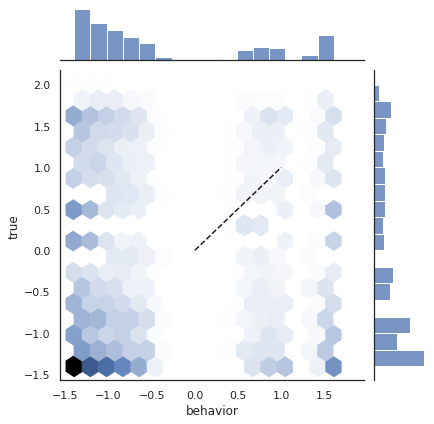

: 

In [20]:
# get correlation between predicted and true speed
from scipy.stats import pearsonr
r, p = pearsonr(behavior_preds['behavior'], behavior_preds['true'])
print(f"r: {r}, p: {p}")
behavior_preds.to_csv(os.path.join(dir_name, 'behavior_pred.csv'), index=False)
behavior_corr_df = pd.DataFrame({'r': [r], 'p': [p]})
behavior_corr_df.to_csv(os.path.join(dir_name, 'behavior_corr.csv'), index=False)
# plot hexplot of predicted vs true speed

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", color_codes=True)
g = sns.jointplot(x="behavior", y="true", data=behavior_preds, kind="hex")
g.ax_joint.plot([0, 1], [0, 1], 'k--')
plt.show()


In [ ]:
from neuroformer.utils import predict_raster_recursive_time_auto, process_predictions

PARALLEL = False
df_pred_paths = list(pathlib.Path(base_path).glob('*.csv'))
# df_pred = pd.read_csv(df_pred_paths[0]) if len(df_pred_paths) > 0 else None 
df_pred = None
results_dict = dict()

top_p = 0.9
top_p_t = 0.9
temp = 1.
temp_t = 1.

test_trials = test_data['Trial'].unique()
# pick 8 trials at random from test
trials = np.random.choice(test_trials, 8, replace=False)

if df_pred is None:
    from joblib import Parallel, delayed
    # Define a function to process each trial
    def process_trial(model, train_dataset, df, stoi, itos_dt, itos, window, window_prev, top_p, top_p_t, temp, temp_t, trial):
        print(f"-- Trial: {trial} --")
        df_trial = df[df['Trial'] == trial]
        trial_dataset = train_dataset.copy(df_trial)
        results_trial = predict_raster_recursive_time_auto(model, trial_dataset, window, window_prev, stoi, itos_dt, itos=itos, 
                                                        sample=True, top_p=top_p, top_p_t=top_p_t, temp=temp, temp_t=temp_t, 
                                                        frame_end=0, get_dt=True, gpu=False, pred_dt=True, plot_probs=False)
        df_trial_pred, df_trial_true = process_predictions(results_trial, stoi, itos, window)
        print(f"pred: {df_trial_pred.shape}, true: {df_trial_true.shape}" )
        return df_trial_pred, df_trial_true

    if PARALLEL:
        # Process each trial in parallel
        results = Parallel(n_jobs=-1)(delayed(process_trial)(model, train_dataset, df, stoi, itos_dt, 
                                                            itos, window, window_prev, top_p, top_p_t, 
                                                            temp, temp_t, trial) for trial in trials)
    else:
        # Process each trial sequentially
        results = []
        for trial in trials:
            results.append(process_trial(model, train_dataset, df, stoi, itos_dt, 
                                            itos, window, window_prev, top_p, top_p_t, 
                                            temp, temp_t, trial))
    # Combine the results from each trial
    for n, (df_trial_pred, df_trial_true) in enumerate(results):   
        print(f"-- No. {n} Trial --")
        if df_pred is None:
            df_pred = df_trial_pred
            df_true = df_trial_true
        else:
            df_pred = pd.concat([df_pred, df_trial_pred])
            df_true = pd.concat([df_true, df_trial_true])



In [ ]:
from analysis import get_rates_trial, calc_corr_psth

df_1 = df[df['Trial'].isin(trials)]
df_pred_full = df_pred

window_pred = 2.5
window_pred = window if window_pred is None else window_pred
df_pred_full = set_intervals(df_pred_full, window, window_prev, window_pred)
df_1 = set_intervals(df_1, window, window_prev, window_pred)

from neuroformer.analysis import compute_scores, compute_scores_scikit
df_true = df[df['Trial'].isin(trials)]
scores = compute_scores(df_1, df_pred)
scores_scikit = compute_scores_scikit(df_1, df_pred)
print(scores)
print(f"len predL: {len(df_pred)}, len true: {len(df_true)}")

model_name = os.path.basename(model_path)
df_pred.to_csv(os.path.join(dir_name, F'df_pred_.csv'))

intervals = np.array(sorted(set(df_pred_full['Interval'].unique()) & set(df_pred_full['Interval'].unique())))
labels = np.array([round(window_pred + window_pred*n, 2) for n in range(0, int(max(df_pred_full['Interval']) / window_pred))])
ids = sorted(set(df['ID'].unique()) & set(df['ID'].unique()))

rates_pred = get_rates_trial(df_pred_full, labels)
rates_1 = get_rates_trial(df_1, labels)

top_corr_pred = calc_corr_psth(rates_pred, rates_1)




In [ ]:
"""

Evaluate results

"""

from neuroformer.visualize import *
from neuroformer.analysis import get_accuracy


len_pred, len_true = len(df_pred_full), len(df_1)
print(f"len_pred: {len_pred}, len_true: {len_true}")

accuracy = get_accuracy(df_pred, df_1)
pred_scores = compute_scores(df_1, df_pred_full)

print(f"pred: {pred_scores}")

n_bins = 30
set_plot_white()
plt.figure(figsize=(10, 10), facecolor='white')
plt.title(f'PSTH Correlations (V1 + AL) {title}', fontsize=25)
plt.ylabel('Count (n)', fontsize=25)
plt.xlabel('Pearson r', fontsize=25)
# plt.hist(top_corr_real_2, label='real - real3', alpha=0.6)
plt.hist(top_corr_pred, label='real - simulated', alpha=0.6, bins=30)
plt.legend(fontsize=20)

dir_name = os.path.dirname(model_path)
model_name = os.path.basename(model_path)

top_p = 0
save_title = f'_top_p{str(top_p).replace(".", "")}'
plt.savefig(os.path.join(dir_name, F'psth_corr_{save_title}_.svg'))
df_pred.to_csv(os.path.join(dir_name, F'df_pred_{save_title}_.csv'))

plot_distribution(df_1, df_pred, save_path=os.path.join(dir_name, F'psth_dist_.svg'))
# save scores to json}}
with open(os.path.join(dir_name, F'scores_{save_title}_.json'), 'w') as fp:
    json.dump(pred_scores, fp)

# save scikit scores to json
with open(os.path.join(dir_name, F'scores_scikit_{save_title}_.json'), 'w') as fp:
    json.dump(scores_scikit, fp)

total_scores = dict()
total_scores['pred'] = pred_scores

print(f"model: {title}")







In [ ]:
iterable = iter(test_dataset)




In [ ]:
# while x['trial'] < 4:

x, y = next(iterable)

T = len(x['id'])
P = x['pad'] - 1
T_prev = len(x['id_prev'])
P_prev = x['pad_prev'] - 4

iv = float(x['interval'])

xid = x['id'][: T - P]
xid = [itos[int(i)] for i in xid]

xid_prev = x['id_prev'][: T_prev - P_prev]
xid_prev = [itos[int(i)] for i in xid_prev]

print(f"iv: {iv}, ix+window: {iv + window} pid: {x['pid']} cid: {x['cid']}")
print(f"x: {xid}")
print(f"xid_prev: {xid_prev}")

if 'behavior' in y:
    t_var = 'Interval' # 'Interval'
    tdiff = 0
    int_var = 'cid'
    y_behavior = y['behavior']
    y_behavior = [itos_speed[int(i)] for i in y_behavior]
    print(f"y_behavior: {y_behavior}")
    true_behavior = print(df_behavior[(df_behavior[t_var] > round(float(x[int_var][0]), 2) - tdiff) & (df_behavior[t_var] <= round(float(x[int_var][1]), 2)) & (df_behavior['Trial'] == int(x['trial']))])
    print(f"true_behavior: {true_behavior}")

tdiff = 0
t_var = 'Time' # 'Interval'
int_var = 'cid'
# df[(df[t_var] >= iv - tdiff) & (df[t_var] <= iv + (window + tdiff)) & (df['Trial'] == int(x['trial']))]
# df[(df[t_var] >= float(x[int_var][0]) - tdiff) & (df[t_var] <= float(x[int_var][1] + tdiff)) & (df['Trial'] == int(x['trial']))]
df[(df[t_var] > float(x[int_var][0]) - tdiff) & (df[t_var] <= float(x['cid'][1] + tdiff)) & (df['Trial'] == int(x['trial']))]

t_var = 'Time' # 'Interval'
int_var = 'cid'
df[(df[t_var] > round(float(x[int_var][0]), 2) - tdiff) & (df[t_var] <= round(float(x[int_var][1]), 2)) & (df['Trial'] == int(x['trial']))]













